<h1>This notebook tracks the spread of the novel coronavirus, also known as SARS-CoV-2. It is a contagious respiratory virus that first started in Wuhan in December 2019. On 2/11/2020, the disease is officially named COVID-19 by the World Health Organization. 
    <br>Data: <a href='https://github.com/CSSEGISandData/COVID-19'>https://github.com/CSSEGISandData/COVID-19</a>. A big thank you to Johns Hopkins for providing the data.
    <br>
    <br>Learn more from the <a href='https://www.who.int/emergencies/diseases/novel-coronavirus-2019'>WHO</a>
    <br>Learn more from the <a href='https://www.cdc.gov/coronavirus/2019-ncov'>CDC</a>
    <br>Map Visualizations from  <a href='https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6'>Johns Hopkins</a>
    <br>Feel free to provide me with feedbacks. 
    <br> Last update: 3/24/2020 11:04 PM
    <br> Make sure you run the notebook to see the graphs better. Some diagrams are hard to see in the default view. 
    <br> <a href='https://github.com/therealcyberlord'>Source code is on my Github</a>
    <br><br> <i>*Johns Hopkins just changed their data structure, some of the visualizations might not be available. This will be addressed in a future commit. </i>
    
</h1>

<center><img src='https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg'>
* Source: https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg </center>

<h1>Keep strong, world! Stay safe everyone.</h1>







In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [18]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
confirmed_df.to_csv('./data/confirmed.csv')
deaths_df.to_csv('./data/deaths.csv')
recoveries_df.to_csv('./data/recoveries.csv')


In [6]:
cols = confirmed_df.keys() # column keys

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20'],
      dtype='object')

Get all the dates for the outbreak

In [21]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]] # date and confirmed cases for that region
deaths = deaths_df.loc[:, cols[4]:cols[-1]] # date and deaths for that region
recoveries = recoveries_df.loc[:, cols[4]:cols[-2]]

In [25]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 
india_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
#     if recoveries.has_key(i):
#         recovered_sum = recoveries[i].sum()
#         total_recovered.append(recovered_sum)
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    

In [32]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [34]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [37]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [39]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.15, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [ ]:
# use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [ ]:
# svm_search.best_params_

In [40]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/Users/siddharthsharma/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 13560.260861178322
MSE: 245362161.63823143


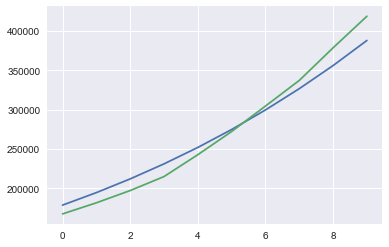

In [41]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [42]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [43]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 8371.667302802462
MSE: 124465613.49655476


In [44]:
print(linear_model.coef_)

[[ 2.62616269e+03 -1.73606469e+03  3.59116139e+02 -7.50095050e+00
  -4.27346470e-02  1.68111854e-03]]


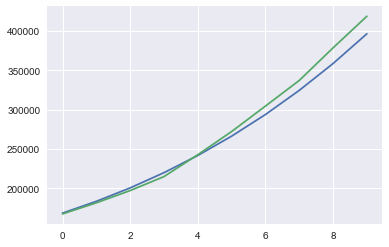

In [45]:
plt.plot(test_linear_pred)
plt.plot(y_test_confirmed)

In [ ]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

In [ ]:
bayesian_search.best_params_

In [ ]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)

 Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

In [ ]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

In [ ]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

In [ ]:
# plt.figure(figsize=(16, 9))
# plt.plot(adjusted_dates, total_active, color='purple')
# plt.title('# of Coronavirus Active Cases Over Time', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Active Cases', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# plt.figure(figsize=(16, 9))
# plt.plot(adjusted_dates, total_recovered, color='green')
# plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [ ]:
# mean_recovery_rate = np.mean(recovery_rate)
# plt.figure(figsize=(16, 9))
# plt.plot(adjusted_dates, recovery_rate, color='blue')
# plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
# plt.title('Recovery Rate of Coronavirus Over Time', size=30)
# plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('Recovery Rate', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

Graphing deaths against recoveries

In [ ]:
# plt.figure(figsize=(16, 9))
# plt.plot(adjusted_dates, total_deaths, color='r')
# plt.plot(adjusted_dates, total_recovered, color='green')
# plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
# plt.title('# of Coronavirus Cases', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

Plotting the number of deaths against the number of recoveries

In [ ]:
# plt.figure(figsize=(16, 9))
# plt.plot(total_recovered, total_deaths)
# plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
# plt.xlabel('# of Coronavirus Recoveries', size=30)
# plt.ylabel('# of Coronavirus Deaths', size=30)
# plt.xticks(size=20)
# plt.yticks(size=20)
# plt.show()

In [ ]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
# latest_recoveries = recoveries_df[dates[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [ ]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [ ]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [ ]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

In [ ]:
unique_provinces =  list(confirmed_df['Province/State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [ ]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==unique_provinces[i]].sum()

In [ ]:
# number of cases per province/state/city
print('Confirmed Cases by Province/States:')
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

In [ ]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

In [ ]:
china_confirmed = latest_confirmed[confirmed_df['Country/Region']=='China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

In [ ]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

In [ ]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

In [ ]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()

In [ ]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per State/Province/Region', size=20)
plt.pie(visual_confirmed_cases2, colors=c)
plt.legend(visual_unique_provinces, loc='best', fontsize=15)
plt.show()

In [ ]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China', size=20)
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best', fontsize=15)
plt.show()

In [ ]:
# # looking at US States
# us_regions = list(confirmed_df[confirmed_df['Country/Region']=='US']['Province/State'].unique())
# us_confirmed_cases = []
# no_cases = [] 
# for i in us_regions:
#     cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
#     if cases > 0:
#         us_confirmed_cases.append(cases)
#     else:
#         no_cases.append(i)
 
# # remove areas with no confirmed cases
# for i in no_cases:
#     us_regions.remove(i)
    
# # only show the top 10 states
# us_regions = [k for k, v in sorted(zip(us_regions, us_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

# for i in range(len(us_regions)):
#     us_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==us_regions[i]].sum()  

# us_regions_10 = us_regions[:10]
# us_regions_10.append('Others')
# us_confirmed_cases_10 = us_confirmed_cases[:10]
# us_confirmed_cases_10.append(np.sum(us_confirmed_cases[10:]))

In [ ]:
# c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
# plt.figure(figsize=(20,15))
# plt.title('Covid-19 Confirmed Cases in the United States',  size=20)
# plt.pie(us_confirmed_cases_10, colors=c)
# plt.legend(us_regions_10, loc='best', fontsize=15)
# plt.show()

In [ ]:
# looking at Chinese provinces
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)
    
china_regions = [k for k, v in sorted(zip(china_regions, china_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(china_regions)):
    china_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==china_regions[i]].sum()  

china_regions_10 = china_regions[:10]
china_regions_10.append('Others')
china_confirmed_cases_10 = china_confirmed_cases[:10]
china_confirmed_cases_10.append(np.sum(china_confirmed_cases[10:]))

In [ ]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the Mainland China', size=20)
plt.pie(china_confirmed_cases_10, colors=c)
plt.legend(china_regions_10, loc='best', fontsize=15)
plt.show()